In [1]:
from os import getcwd
from os.path import abspath, join

from copy import deepcopy
from joblib import parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.data.load_dataset import load_mnist
from src.models.estimator import RFClassifier, relu
from src.models.weights import V1_weights, classical_weights

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

In [3]:
# load dataset
train_loader, val_loader, test_loader = load_mnist()
train, test = train_loader.dataset.dataset, test_loader.dataset
train, train_labels = train.data.numpy(), train.targets.numpy()
X_test, y_test = test.data.numpy(), test.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, train_size=0.999, stratify=train_labels)

# params
h = 1000
bias = 0
nonlinearity = relu
scale = 1
center = None
clf = LinearSVC(tol=1e-4, max_iter=1000)
n_jobs=5
cv = 3

In [4]:
grid = np.arange(1, 20, 1)
size, spatial_freq = np.meshgrid(grid, grid)
params = np.array(list(zip(size.flatten(), spatial_freq.flatten())))

In [ ]:
accuracy = np.zeros((len(params), cv))
for i, [s, f] in enumerate(tqdm(params)):
    kwargs = {'size':s, 'spatial_freq': f, 'center': None, 'scale': scale}
    v1_clf = RFClassifier(h, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs)
    scores = cross_val_score(v1_clf, X_train, y_train, cv=cv, n_jobs=n_jobs, verbose=0)
    accuracy[i] = scores
    
    # save results iteratively
    param_study = {'size': params[:, 0], 'spatial_freq': params[:, 1],  'scores': accuracy}
    with open(data_dir + '/models/results/mnist_clf/mnist_param_study_estimator.pickle', 'wb') as file:
        pickle.dump(param_study, file)

  0%|          | 0/361 [00:00<?, ?it/s]

8 3 0.9443276609943277 [0.94414414 0.94604605 0.94279279]


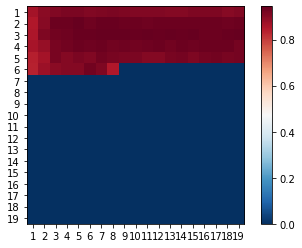

In [3]:
with open(data_dir + '/models/results/kmnist_clf/kmnist_param_study_estimator.pickle', 'rb') as file:
    results = pickle.load(file)
    
grid = np.arange(1, 20, 1)
mean = np.mean(results['scores'], axis=1)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(mean.reshape(19, 19), cmap='RdBu_r')
plt.xticks(grid - 1)
plt.yticks(grid - 1)
ax.set_xticklabels(grid)
ax.set_yticklabels(grid)
# plt.imshow(results['scores'])
plt.colorbar()

# print the largest param
idx = np.argmax(mean)
print(results['size'][idx], results['spatial_freq'][idx], mean[idx], results['scores'][idx])